In [1]:
import pandas as pd
import lecilab_behavior_analysis.utils as utils
from pathlib import Path
%load_ext autoreload
%autoreload 2

In [2]:
# mouse = "mouse2"
# df = utils.load_example_data(mouse)

In [3]:
# load data from cluster
tv_projects = utils.get_server_projects()
print(tv_projects)

['COT_test_data', 'visual_and_COT_data']


In [4]:
# see the available animals
animals = utils.get_animals_in_project(tv_projects[1])
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010']


In [5]:
# download the data for a specific animal

# mouse = "mouse2"
# df = utils.load_example_data(mouse)

mouse = "ACV001"
local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
# download the session data
utils.rsync_cluster_data(
    project_name=tv_projects[1],
    file_path="sessions/{}/{}.csv".format(mouse, mouse),
    local_path=str(local_path),
    credentials=utils.get_idibaps_cluster_credentials(),
)

bind [127.0.0.1]:8050: Address already in use
channel_setup_fwd_listener_tcpip: cannot listen to port: 8050
bind [127.0.0.1]:27001: Address already in use
channel_setup_fwd_listener_tcpip: cannot listen to port: 27001
Could not request local forwarding.


receiving incremental file list
ACV001.csv

sent 128,063 bytes  received 162,378 bytes  25,255.74 bytes/sec
total size is 334,997,227  speedup is 1,153.41


True

In [6]:
# load the data
df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")

/tmp/ipykernel_433227/1822815569.py:2: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


In [7]:
# # engagement analysis
# from lecilab_behavior_analysis import df_transforms as dft
# df = dft.add_trial_duration_column_to_df(df)
# df = dft.add_engagement_column(df, engagement_sd_criteria=2)
# # load events
# events_df = utils.load_all_events(project_name=tv_projects[1])
# sbu_df = dft.get_box_usage_df(df, events_df)
# sbu_df = dft.add_day_column_to_df(sbu_df)

In [8]:
# from lecilab_behavior_analysis import plots
# plots.plot_box_usage_by_date(sbu_df)

/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/df_transforms.py:645: RuntimeWarning: Mean of empty slice
  mean_s = np.nanmean(port_holds)
/home/hmv/anaconda3/envs/dev/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Subject mismatch for 2025-03-05 17:14:38: expected ACV001, found ACV008.
Subject mismatch for 2025-03-07 01:39:11: expected ACV001, found ACV008.
Subject mismatch for 2025-03-12 07:58:54: expected ACV001, found ACV008.
Subject mismatch for 2025-04-02 08:44:36: expected ACV001, found ACV003.
No end event found after date 2025-07-25 10:08:35.
No end event found after date 2025-07-25 10:44:47.


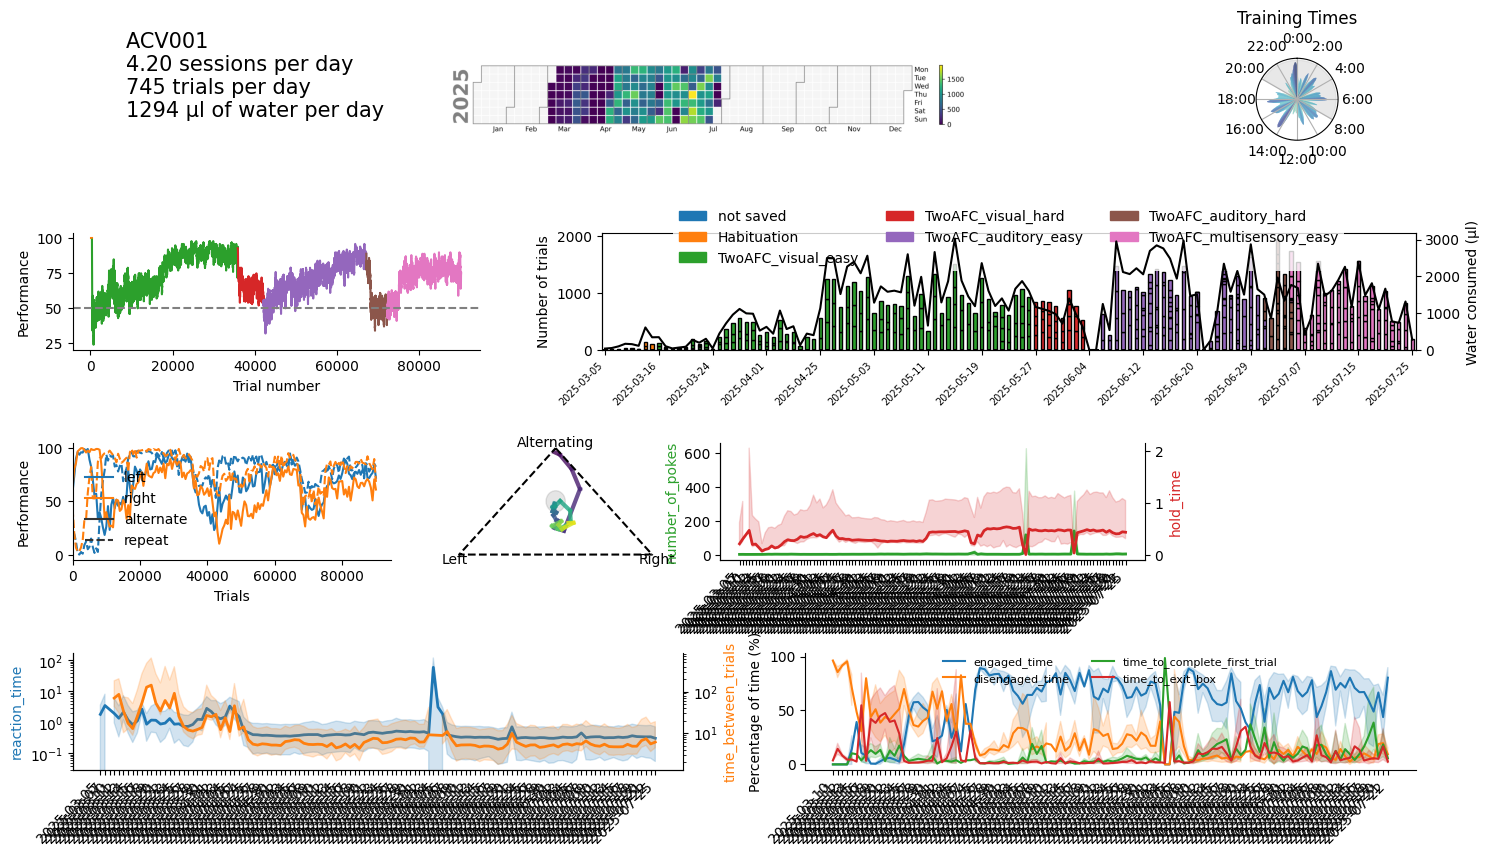

In [9]:
from lecilab_behavior_analysis.figure_maker import subject_progress_figure
# load events
events_df = utils.load_all_events(project_name=tv_projects[1])
fig = subject_progress_figure(df, perf_window=100, summary_matrix_plot=False, events_df=events_df)

In [ ]:
# # load the data if cluster is down
# mouse_path = utils.get_outpath() + "/visual_and_COT_data/sessions/ACV008/ACV008.csv"
# df = pd.read_csv(mouse_path, sep=";")

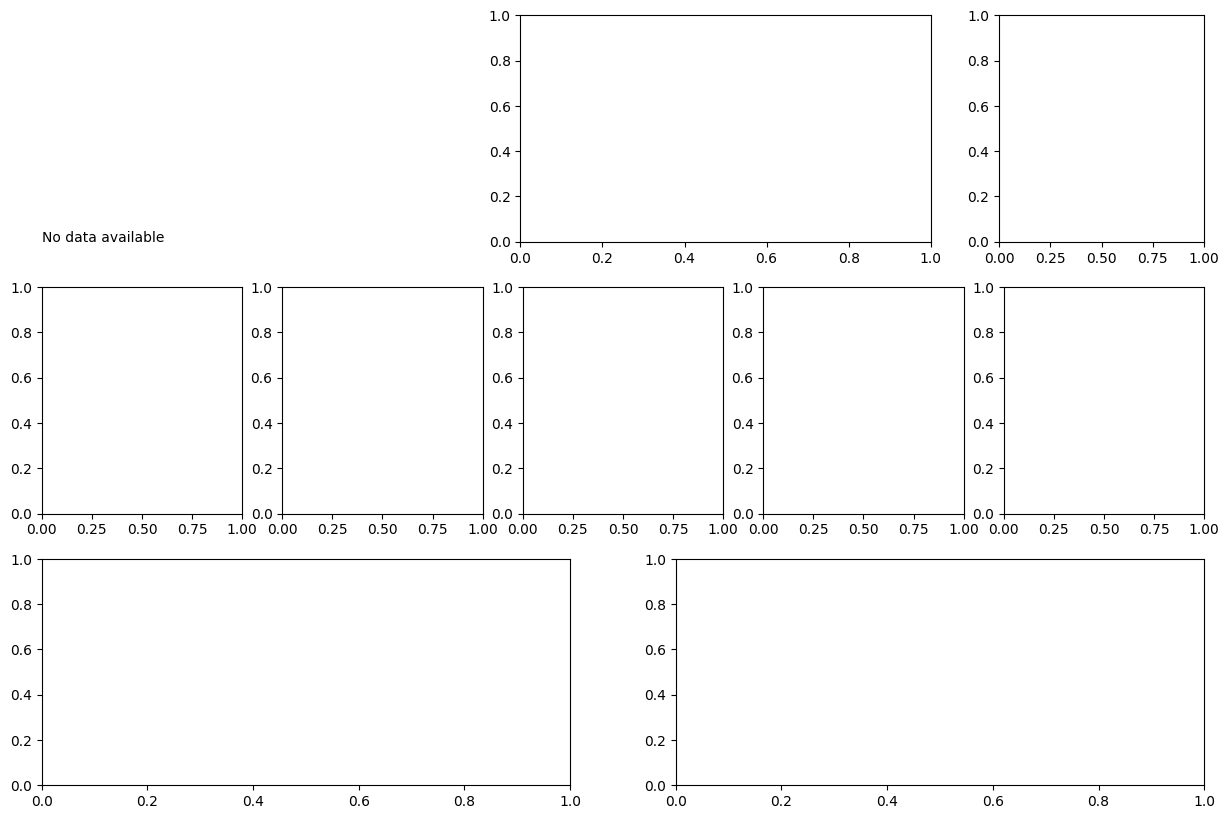

In [13]:
from lecilab_behavior_analysis.figure_maker import session_summary_figure
from lecilab_behavior_analysis.df_transforms import add_trial_of_day_column_to_df, add_day_column_to_df
import numpy as np
# select the session you want to plot
date = "2025-07-24"
# df = analyze_df(df)
df = add_day_column_to_df(df)
df = add_trial_of_day_column_to_df(df)
df['total_trial'] = np.arange(1, df.shape[0] + 1)
sdf = df[df["year_month_day"] == date]
# sdf = df[df["current_training_stage"] == "TwoAFC_auditory_hard"]
fig = session_summary_figure(sdf, perf_window=50, width=15, height=10)

In [43]:
from lecilab_behavior_analysis import df_transforms as dft
from lecilab_behavior_analysis import utils
sdf = utils.add_time_from_session_start(sdf)

/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/utils.py:930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in['time_from_start'] = df_in.groupby(['subject', 'session'])['TRIAL_START'].transform(lambda x: x - x.iloc[0])


In [44]:
sdf[sdf.session != sdf.session.shift(1)].index

Index([86351, 86654, 86655, 86886], dtype='int64')

In [47]:
sdf = dft.adjust_trials_and_time_of_start_to_first_session(sdf)

<Axes: xlabel='Trial start time (s)', ylabel='Trial number'>

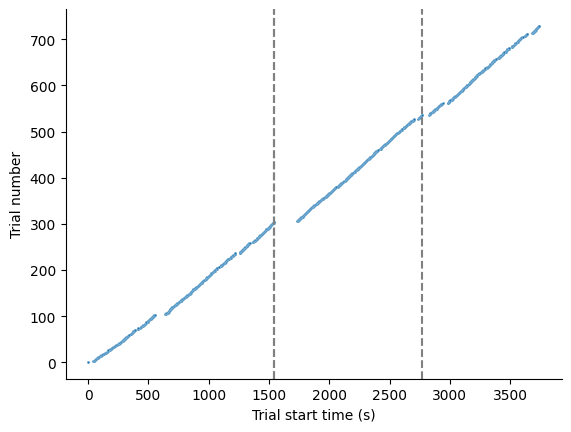

In [48]:
from lecilab_behavior_analysis import plots
# find the index of the session changes
session_changes = sdf[sdf.session != sdf.session.shift(1)].index
plots.plot_trial_time_of_start(sdf, session_changes=session_changes, width=15, height=10)